In [1]:
import os
import numpy as np
import pandas as pd
import graphlab as gl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

This non-commercial license of GraphLab Create for academic use is assigned to trentwoodbury@gmail.com and will expire on October 07, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1475875357.log


In [2]:
ratings_path = os.path.join('data','ratings.dat')
submission_path = os.path.join('data','sample_submission.csv')
ratings = gl.SFrame(ratings_path, format='tsv')
submission = gl.SFrame(submission_path, format='csv')

Finished parsing file /Users/Trent/data_science/case_studies/joke_recommender/data/ratings.dat

Parsing completed. Parsed 100 lines in 1.20837 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/Trent/data_science/case_studies/joke_recommender/data/ratings.dat

Parsing completed. Parsed 1218325 lines in 0.918835 secs.

Finished parsing file /Users/Trent/data_science/case_studies/joke_recommender/data/sample_submission.csv

Parsing completed. Parsed 100 lines in 0.276946 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/Trent/data_science/case_studies/joke_recommender/data/sample_submission.csv

Parsing completed. Parsed 522169 lines in 0.377945 secs.

In [3]:
ratings

user_id,joke_id,rating
34888,111,-9.71875
49651,119,4.75
29027,137,2.625
25235,30,-2.4375
50499,19,2.1875
7300,51,9.3125
30219,9,2.3125
29443,134,3.1875
27069,128,1.21875
24450,120,10.0


In [4]:
pd_ratings = pd.Series(ratings['rating'])
pd_ratings.describe()

count    1.218325e+06
mean     1.700198e+00
std      5.285761e+00
min     -1.000000e+01
25%     -1.906250e+00
50%      2.312500e+00
75%      5.812500e+00
max      1.000000e+01
dtype: float64

Jokes appear to be rated on a scale from -10 to 10. We assume -10 would be an offensive, unfunny joke, and 10 is hilarity.

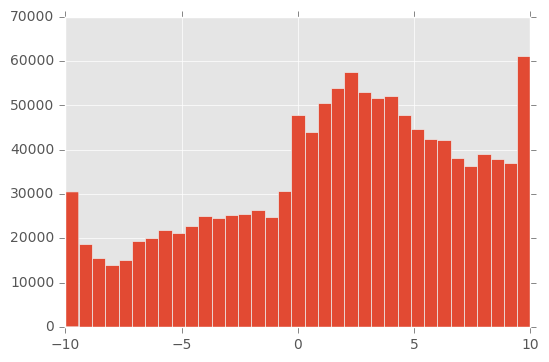

In [5]:
pd_ratings.hist(bins=35)

In [12]:
params = {'user_id': 'user_id', 'item_id' : 'joke_id',  'target': 'rating', 'solver' :'als', 
          'regularization' : 1e-8, 'max_iterations' : 30,
         'num_factors': 25}

grid_search = gl.toolkits.model_parameter_search.grid_search.create(ratings,\
                                    gl.recommender.factorization_recommender.create, params)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Oct-07-2016-15-50-5200000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Oct-07-2016-15-50-5200000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Oct-07-2016-15-50-5200000' already exists. Renaming the job to 'Model-Parameter-Search-Oct-07-2016-15-50-5200000-28009'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Oct-07-2016-15-50-5200000-28009' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Oct-07-2016-15-50-5200000-28009' scheduled.


In [13]:
grid_search.get_results()

Columns:
	model_id	int
	item_id	str
	max_iterations	int
	num_factors	int
	regularization	float
	solver	str
	target	str
	user_id	str
	training_precision@5	float
	training_recall@5	float
	training_rmse	float

Rows: 1

Data:
+----------+---------+----------------+-------------+----------------+--------+
| model_id | item_id | max_iterations | num_factors | regularization | solver |
+----------+---------+----------------+-------------+----------------+--------+
|    0     | joke_id |       30       |      25     |     1e-08      |  als   |
+----------+---------+----------------+-------------+----------------+--------+
+--------+---------+----------------------+-------------------+---------------+
| target | user_id | training_precision@5 | training_recall@5 | training_rmse |
+--------+---------+----------------------+-------------------+---------------+
| rating | user_id |    0.101526868145    |  0.0584620013695  | 1.99210206272 |
+--------+---------+----------------------+-------------------+---------------+
[1 rows x 11 columns]

In [15]:
rec_engine = gl.factorization_recommender.create(observation_data=ratings,
                                                     user_id="user_id",
                                                     item_id="joke_id",
                                                     target='rating',
                                                     solver='als',
                                                     side_data_factorization=False,
                                                     regularization=1e-8,
                                                     max_iterations=40,
                                                     num_factors = 35)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 1218325 observations with 50692 users and 141 items.

Data prepared in: 1.52129s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 35       |

| regularization               | L2 Regularization on Factors                     | 1e-08    |

| max_iterations               | Maximum Number of Iterations                     | 40       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 108us        | NA                     |

+---------+--------------+------------------------+

| 0       | 3.84s        | 3.04908                |

| 1       | 7.83s        | 1.82309                |

| 2       | 11.65s       | 1.79599                |

| 3       | 16.23s       | 1.77486                |

| 4       | 20.21s       | 1.75757                |

| 5       | 24.22s       | 1.74311                |

| 6       | 28.91s       | 1.73081                |

| 7       | 33.68s       | 1.7202                 |

| 8       | 38.36s       | 1.71099                |

| 9       | 42.91s       | 1.7029                 |

| 10      | 46.98s       | 1.69572                |

| 11      | 50.96s       | 1.6893                 |

| 12      | 55.67s       | 1.68354                |

| 13      | 1m 0s        | 1.67832                |

| 14      | 1m 4s        | 1.67358                |

| 15      | 1m 9s        | 1.66925                |

| 16      | 1m 13s       | 1.6653                 |

| 17      | 1m 17s       | 1.66165                |

| 18      | 1m 21s       | 1.65828                |

| 19      | 1m 25s       | 1.65514                |

| 20      | 1m 29s       | 1.65221                |

| 21      | 1m 32s       | 1.64946                |

| 22      | 1m 36s       | 1.64686                |

| 23      | 1m 40s       | 1.64441                |

| 24      | 1m 44s       | 1.64209                |

| 25      | 1m 48s       | 1.6399                 |

| 26      | 1m 52s       | 1.63783                |

| 27      | 1m 56s       | 1.63587                |

| 28      | 2m 0s        | 1.63402                |

| 29      | 2m 4s        | 1.63227                |

| 30      | 2m 8s        | 1.63061                |

| 31      | 2m 13s       | 1.62903                |

| 32      | 2m 17s       | 1.62753                |

| 33      | 2m 21s       | 1.62611                |

| 34      | 2m 25s       | 1.62476                |

| 35      | 2m 29s       | 1.62348                |

| 36      | 2m 33s       | 1.62225                |

| 37      | 2m 37s       | 1.62108                |

| 38      | 2m 42s       | 1.61997                |

| 39      | 2m 46s       | 1.6189                 |

| FINAL   | 2m 46s       | 1.6189                 |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

In [16]:
predictions = np.array(rec_engine.predict(submission))
pos_mask = np.where(predictions > 10)[0]
neg_mask = np.where(predictions < -10)[0]
predictions[pos_mask] = 10
predictions[neg_mask] = -10
print predictions.max(), predictions.min()

10.0 -10.0


(-20, 20)

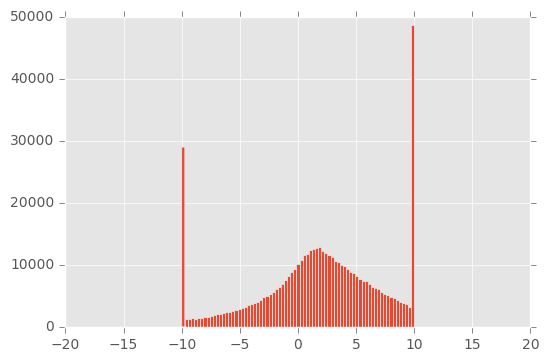

In [17]:
predictions
pd.Series(predictions).hist(bins=75)
plt.xlim(-20, 20)

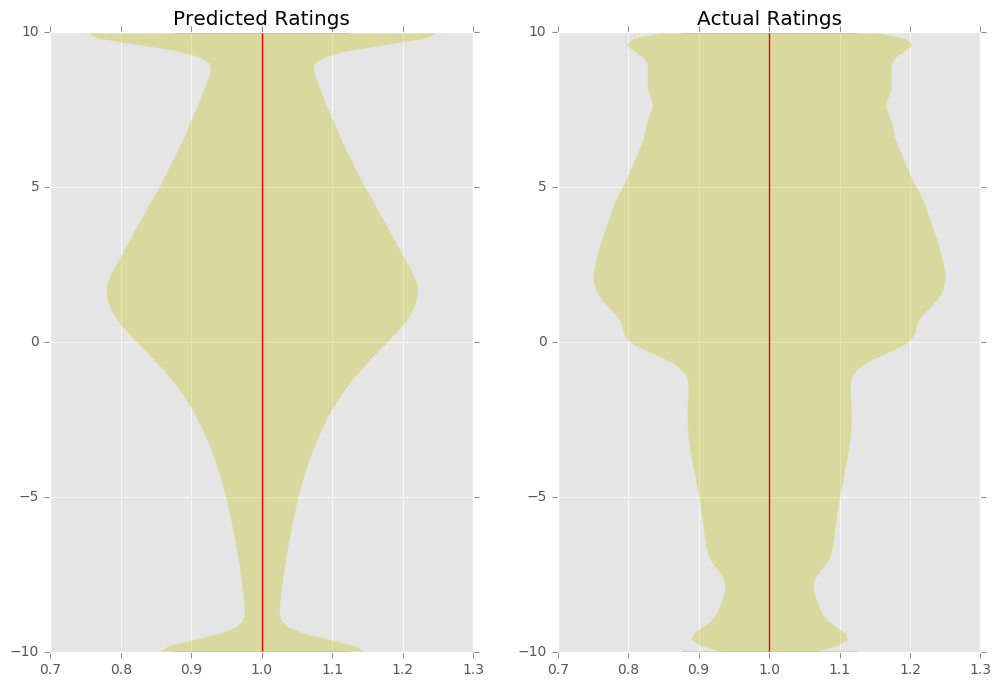

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,2,1)
ax1.violinplot(predictions)
ax1.set_title('Predicted Ratings')
ax2 = fig.add_subplot(1,2,2)
ax2.violinplot(pd_ratings)
ax2.set_title('Actual Ratings')

In [20]:
def get_recs(predictions, submission):
    sample_sub = pd.read_csv(submission)
    for_prediction = gl.SFrame(sample_sub)
    sample_sub.rating = predictions
    sample_sub.to_csv("data/test_ratings.csv", index=False)

In [21]:
get_recs(predictions, submission_path)